# Hands-on Session on Convolutional Neural Net(CNN)
     
From this hands-on session on CNN you will learn 
    1. Cfar-10 dataset.       
    2. Basic tensor operations in tensorflow. 
    3. How to classify natural images using a simple neural network
    4. Design your own CNN architecture.

* prerequisites
    1. pyhton 3  
    2. tensorflow 2 
    3. 2D computer vision
    4. deep learning

In [1]:
# import packages
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import numpy as np
import time

from matplotlib import pyplot as plt
from toolz import *
from itertools import *

import logging
tf.get_logger().setLevel(logging.ERROR)

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


## Cifar10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [2]:
# load dataset using tf.keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
txtLabels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

170500096/170498071 [==============================] - 4s 0us/step


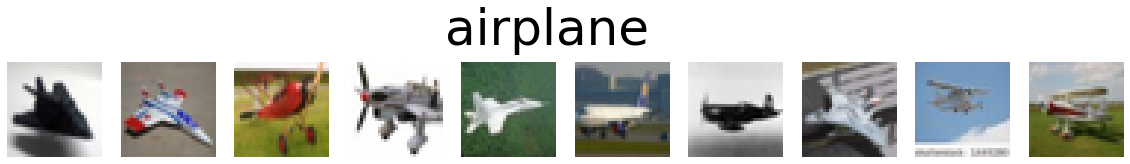

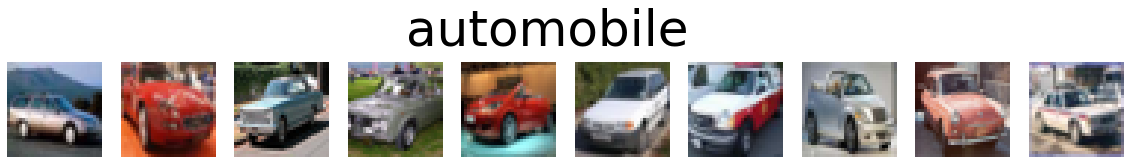

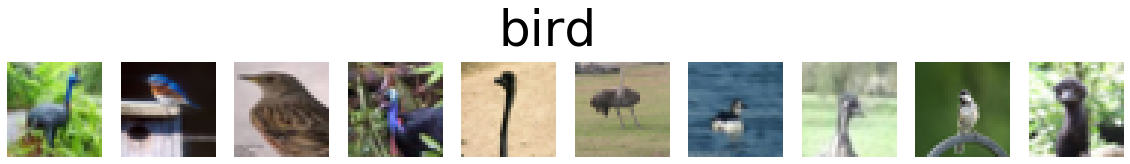

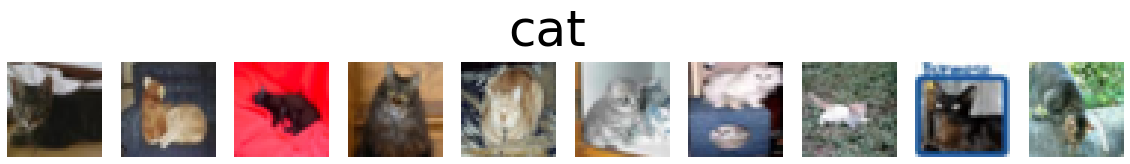

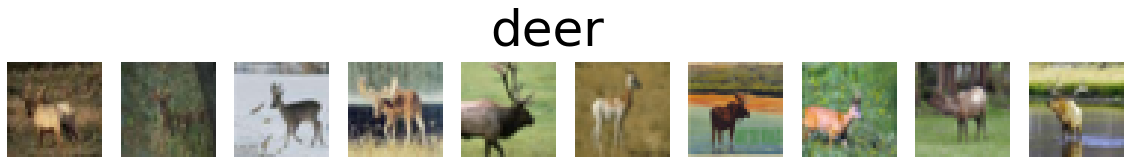

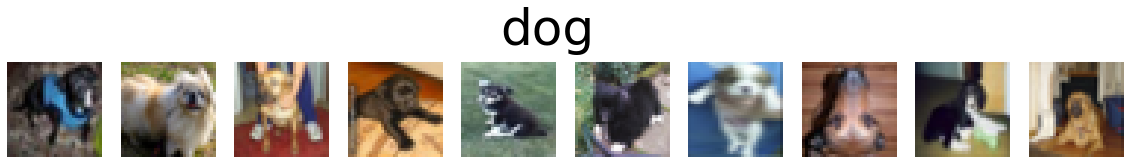

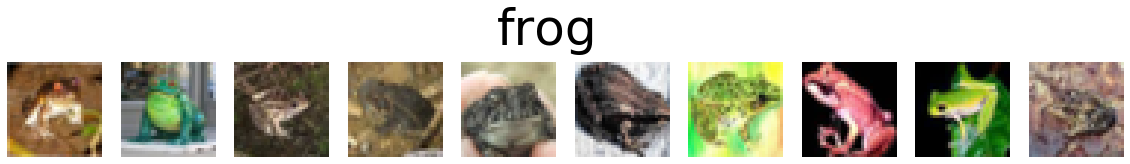

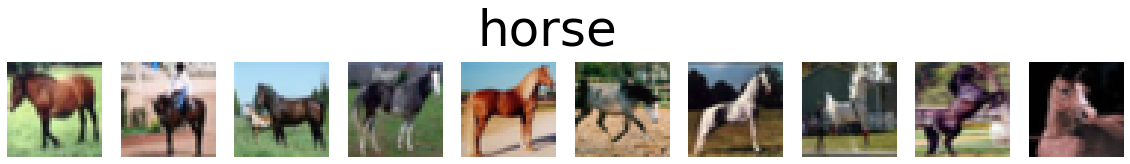

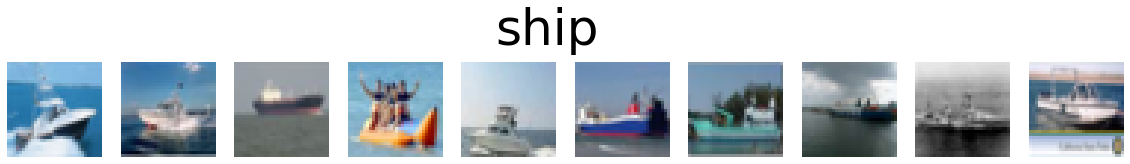

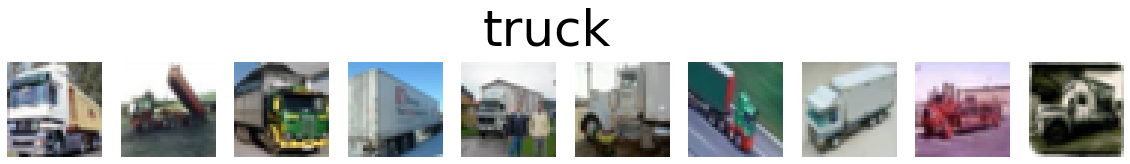

number of training data : 50000 
number of testing  data : 10000 
number of classes       : 10


number of images per class in training data : 
{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}


number of images per class in testing data : 
{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


In [3]:
def showImsLabs(images, labs, dim = None, title = None):
    
    byLab = lambda imglab : imglab[1]
    byImg = lambda imglab : imglab[0]
    
    imgsPerlabs = [(lab,list(map(byImg,imgs))) for lab,imgs in groupby(sorted(zip(images, np.squeeze(labs)), key = byLab), key = byLab)]
    
    for lab,imgs in imgsPerlabs:
        
        imgs = imgs[:10]
        imgN = len(imgs)
        fig, axes = plt.subplots(1,imgN, figsize = (imgN * 2, 1 * 3))

        fig.suptitle("%s" % txtLabels[lab], fontsize=50)

        for ax,img in zip(axes,imgs): 

            ax.imshow(img)
            ax.axis('off')

        plt.show()
        
showImsLabs(x_train, y_train, dim = None, title = None)      

print("number of training data : %s " % (len(x_train)))
print("number of testing  data : %s " % (len(x_test)))
print("number of classes       : %s" % (len(np.unique(y_train))))

print("\n")
print("number of images per class in training data : ")
print(dict(zip(txtLabels,np.bincount(np.squeeze(y_train)))))
print("\n")
print("number of images per class in testing data : ")
print(dict(zip(txtLabels,np.bincount(np.squeeze(y_test)))))

## Tensorflow 2
TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications.

In [5]:
# tensorflow offers numorous tensor operators which can be found on numpy. Under the hood GPU is parallelising the operation.

def TIME(f):
    
    def inner(*args,**kwargs):
        
        t0 = time.time() 
        output = f(*args,**kwargs)
        t1 = time.time()   
        
        print("time taken for %s :: %1.4f " % (f.__name__ , t1-t0) )
        
        return output 
    
    return inner

@TIME
def numpyMUL(X,Y):
    return np.matmul(X,Y)

@TIME
def tensorMUL(X,Y):
    return tf.matmul(X,Y)

X = np.random.normal(size = [10000,1000])
Y = np.random.normal(size = [1000 ,10000])

XT = tf.random.normal([10000,1000])
YT = tf.random.normal([1000 ,10000])

XY   = numpyMUL(X,Y)
TFXY = tensorMUL(XT,YT)

time taken for numpyMUL :: 5.2916 
time taken for tensorMUL :: 0.0036 


### Good functions to know in tensorflow ###

In [ ]:
# convert numpy to tensor
x = tf.convert_to_tensor(np.random.normal(size = [224,224,3]))
# retrieve back numpy from tensor 
y1 = x.numpy()
# take mean of values at certain axis 
y1 = tf.reduce_mean(x, axis = -1)
# take max of values at certain axis 
y2 = tf.reduce_sum(x, axis  = -1)
# conditional tensor opertion
y3 = tf.where(x > 0 ,0.0, 1.0)
# similar to map function but takes in tensor and ouput tensor
y4 = tf.map_fn(lambda x : x**2, x)

### Prebuilt commonly used layers

In [ ]:
x = tf.convert_to_tensor(x_train[:3], dtype = tf.float32)

#convolutional layer with 16 (3 x 3) filters
conv16 = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3)) 
#relu layer
relu = tf.keras.layers.ReLU()
#pooling layer
pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))
# batch normalisation layer 
batchNorm = tf.keras.layers.BatchNormalization()
# flatten layer 
flatten = tf.keras.layers.Flatten()
Dense   = tf.keras.layers.Dense(10)
# softmax layer 
softmax = tf.keras.layers.Activation('softmax')

### Using **kera.models.Sequential** to design an architecture. 

In [ ]:
def create_model(inputShape):
    
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]),        
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]),        
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Dense(10)])
    
    return model

## Classsification of CiFar10 using CNN 

### 1. Design your model

In [ ]:
def create_model(inputShape):
    
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]),        
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]),        
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Dense(10)])
    
    return model

### 2. Set hyper-parameters for training schedule

In [ ]:
# hyper parameter setting
epochs        = 1
batchSize     = 128
learningRate  = 0.001
SGD           = tf.keras.optimizers.Adam(learning_rate = learningRate)

myNet = create_model([32,32,3])

computeACC  = tf.keras.metrics.Accuracy() 
computeLOSS = tf.nn.sparse_softmax_cross_entropy_with_logits

### 3. Create a data pipeline using **tf.data**

In [12]:
# Easy data pipeline control using tf.data

from tensorflow import image as augmentation

train_generator = tf.data.Dataset.from_generator(lambda : zip(x_train, y_train),
                                                 (tf.float64,tf.int32),
                                                 (tf.TensorShape([32,32,3]), tf.TensorShape(None)))

train_generator = train_generator.\
    map(lambda img,lab  : (augmentation.random_flip_left_right(img), lab)).\
    map(lambda img,lab  : (augmentation.random_flip_up_down(img), lab)).\
    map(lambda img,lab  : (augmentation.per_image_standardization(img), lab)).\
    shuffle(1000).\
    batch(batchSize)


test_generator = tf.data.Dataset.from_generator(lambda : zip(x_test, y_test),
                                                 (tf.float64,tf.int32),
                                                 (tf.TensorShape([32,32,3]), tf.TensorShape(None)))

test_generator = test_generator.\
    map(lambda img,lab  : (augmentation.per_image_standardization(img), lab)).\
    batch(batchSize)

Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f6a84a7e840>. It was defined on this line: train_generator = train_generator.    map(lambda img,lab  : (augmentation.random_flip_left_right(img), lab)).    map(lambda img,lab  : (augmentation.random_flip_up_down(img), lab)).    map(lambda img,lab  : (augmentation.per_image_standardization(img), lab)).    shuffle(1000).    batch(batchSize)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f6a84a7e950>. It was defined on this line: train_generator = train_generator.    map(lambda img,lab  : (augmentation.random_flip_left_right(img), lab)).    map(lambda img,lab  : (augmentation.random_flip_up_down(img), lab)).    map(lambda img,lab  : (augmentation.per_image_standardization(img), lab)).    shuffle(1000).    batch(batchSize)
, which must contain a sing

### 4. Main script for training & testing 

epoch : 0 iteration : 0
    train loss = 2.32
    train acc  = 0.11


epoch : 0 iteration : 50
    train loss = 1.75
    train acc  = 0.25


epoch : 0 iteration : 100
    train loss = 1.46
    train acc  = 0.39


epoch : 0 iteration : 150
    train loss = 1.41
    train acc  = 0.43


epoch : 0 iteration : 200
    train loss = 1.23
    train acc  = 0.48


epoch : 0 iteration : 250
    train loss = 1.33
    train acc  = 0.49


epoch : 0 iteration : 300
    train loss = 1.48
    train acc  = 0.50


epoch : 0 iteration : 350
    train loss = 1.12
    train acc  = 0.52




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




**************************************************
epoch : 0
    test acc  = 0.56
**************************************************


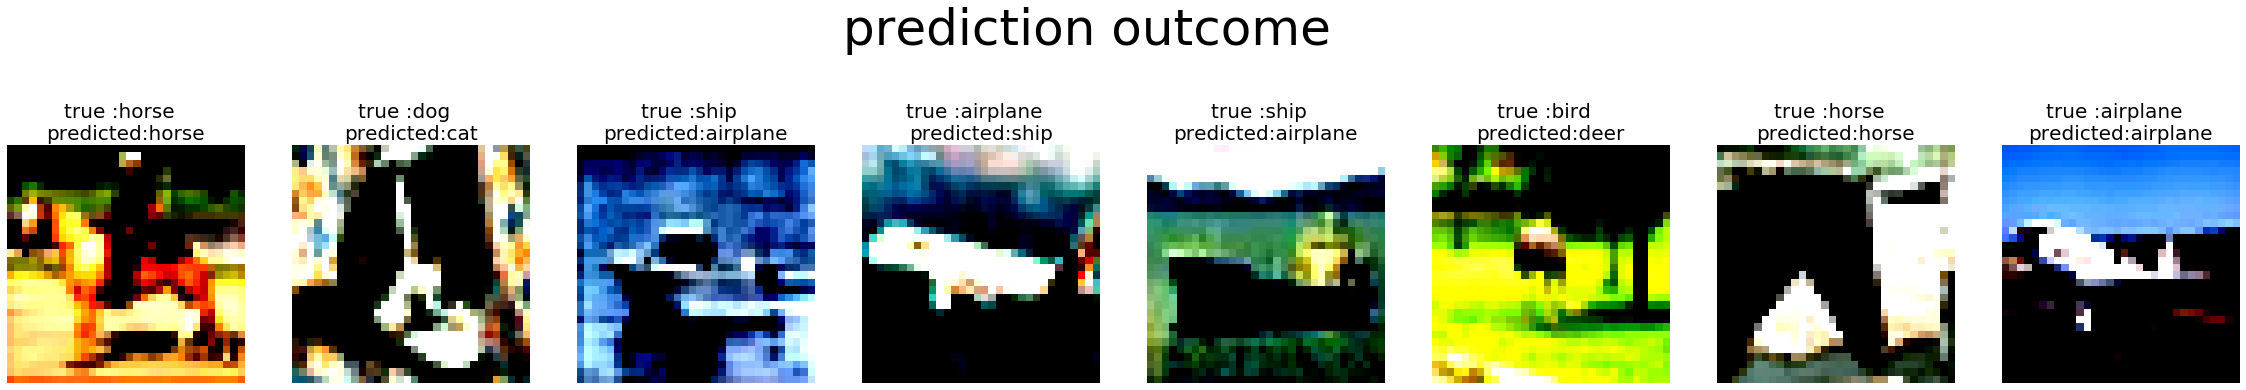

In [13]:
def train_step(imgBatch, labelBatch, net, optimizer):
        
    predLabelBatch = net(imgBatch)
        
    loss = tf.reduce_mean(computeLOSS(tf.squeeze(labelBatch), predLabelBatch))
    computeACC.update_state(tf.argmax(predLabelBatch, axis = 1), tf.squeeze(labelBatch))
    
    return loss, computeACC

def test_step(imgBatch, labelBatch, net):
    
    predLabelBatch = net(imgBatch)
    
    computeACC.update_state(tf.argmax(predLabelBatch, axis = 1), tf.squeeze(labelBatch))
    
    return computeACC, predLabelBatch

def plotBatch(imgBatch, labelBatch, predLabelBatch):
    
    imgs  = imgBatch.numpy()[:8]
    labs  = tf.squeeze(labelBatch).numpy()[:8]
    preds = tf.argmax(predLabelBatch, axis = -1).numpy()[:8]
    
    fig, axes = plt.subplots(1,len(imgs), figsize = (len(imgs) * 5, 1.5 * 5))
    fig.suptitle("prediction outcome" , fontsize=50)

    for ax,img,lab,pred in zip(axes,imgs,labs,preds): 
        ax.imshow(img)
        ax.set_title("true :%s  \npredicted:%s" % (txtLabels[lab],txtLabels[pred]), fontsize=20)
        ax.axis('off')
    

    plt.show()
    
for e in range(epochs) :

    for i, batch in enumerate(train_generator):

        imgBatch, labelBatch = batch

        with tf.GradientTape() as tape:
            loss, acc = train_step(imgBatch, labelBatch, myNet, SGD)

        grads = tape.gradient(loss, myNet.trainable_variables)
        SGD.apply_gradients(zip(grads,myNet.trainable_weights))

        if i % 50 == 0:
            print("epoch : %s iteration : %s" % (e, i))
            print("    train loss = %1.2f" % loss)
            print("    train acc  = %1.2f" % acc.result().numpy())
            print("\n")
            acc.reset_states()
            
    for batch in test_generator:

        imgBatch, labelBatch = batch
        acc, predLabelBatch = test_step(imgBatch, labelBatch, myNet)
        
    print("\n")
    print("*" * 50)
    print("epoch : %s" % (e))
    print("    test acc  = %1.2f" % acc.result().numpy())
    print("*" * 50)
    
    plotBatch(imgBatch, labelBatch, predLabelBatch)
    
    acc.reset_states()